In [1]:
import fit_classes as fp
import numpy as np
import os
import pandas as pd

errors = []
ERROR = 1 
def data_from_file(file):
    file_path = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), file)
    name = str(file_path).split("/")[-1].split("\\")[-1]
    df = pd.read_csv(file_path, delimiter=';', decimal=',')
    df.columns = df.columns.str.strip()

    SKIP1 = 1
    SKIP2_ =17
    SKIP2 = SKIP2_

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "superposition.txt")
    vals = []
    var = None
    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(int, line.strip().split(": ")[-1].strip("()").split(", ")))))

    check = False

    for var in vals:
        if var[0] == name:
            SKIP1, SKIP2 = var[1]
            check = True

    if not check:
        if True:
            values = (SKIP1, SKIP2)
            with open(file_p, "a") as file:
                file.write(f"{name}: {values}\n")

    x1 = df["Latest: Time (s)"].to_numpy()[::SKIP1]
    x2 = df["Latest: Time (s)"].to_numpy()[::SKIP2]
    y1 = df["Latest: Potential 1 (V)"].to_numpy()[::SKIP1]
    y2 = df["Latest: Potential 2 (V)"].to_numpy()[::SKIP2]
    dy1 = ERROR*np.ones_like(y1)
    dy2 = ERROR*np.ones_like(y2)

    # data1 = fp.Data(x1, y1, dy1, name=str(file_path).split('/')[-1][0:-4].split("\\")[-1] + '_1')
    # data2 = fp.Data(x2, y2, dy2, name=str(file_path).split('/')[-1][0:-4].split("\\")[-1]  + '_2')
    data1 = fp.Data(x1, y1, dy1, name=os.path.splitext(os.path.basename(file_path))[0] + '_1')
    data2 = fp.Data(x2, y2, dy2, name=os.path.splitext(os.path.basename(file_path))[0] + '_2')

    if not check:
        print(data2.name)
        data2.show()
    return data1, data2

        
def load_data_by_folder(root):
    folder_data = {}
    total_files = 0
    total_files += len([f for f in os.listdir(root)])

    current_file = 0
    data_list_input = []
    data_list = []
    for file in os.listdir(root):
        file_path = os.path.join(root, file)
        if os.path.isfile(file_path) and file.lower().endswith(".csv"):
            current_file += 1
            # os.system(f'echo "File: {current_file:>3}/{total_files}"')
            data1, data2 = data_from_file(file_path)
            data_list_input.append(data1)
            data_list.append(data2)
        
    if data_list:
        folder_data = np.array(data_list)
    return folder_data

data_arrays = load_data_by_folder(os.path.join(os.path.abspath(os.getcwd()), "data"))


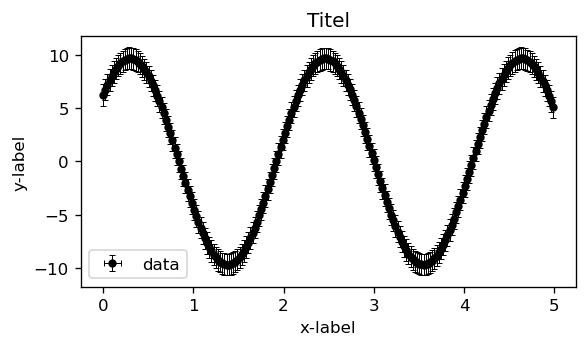

In [2]:
datadict = {}
for dataset in data_arrays:
    datadict[dataset.name[0:-2]] = dataset # ON windows
    # if dataset[1].name == '2-5_190Hz_2':
    # print(dataset.name)
    # dataset.show()
         
datadict["2-3_250Hz"].show()

# Opgave 1

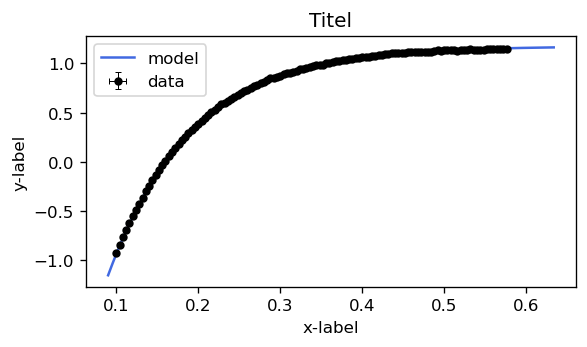

----------------------------------------------------------------------------------------------------------------
For parameter tau      :     $      0.10244 \pm      0.00039 $
For parameter a        :     $      1.17432 \pm      0.00180 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          51.20400389
Reduced χ² value       :     χ²_red           0.43393224
P-value                :     p-value          0.99999999
----------------------------------------------------------------------------------------------------------------



In [7]:
ERROR = 0.01
dataset = fp.Data(datadict["2-1"].x[25:145], datadict["2-1"].y[25:145], ERROR*datadict["2-1"].dy[25:145])

def model_opgave1(params, x):
    tau,a = params
    return (1-np.exp(-(x-0.160)/tau))*a

dataset.fit(model_opgave1).show()
print(dataset.fit(model_opgave1))

# Opgave 2

In [15]:
ERROR = 0.01
files = []
files_opdracht2 = []
for key in datadict:
    if key[0:3] == "2-2":
        files.append(fp.Data(datadict[key].x, datadict[key].y, ERROR*datadict[key].dy, name=datadict[key].name))

def sinus_model(params, x):
    A,f,phi,c = params
    return A*np.sin(2*np.pi*f*x + phi) + c

        
for dataset in files:
    A = 1.25
    f = 6
    phi = np.pi
    c = 0

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "guesses_opgave2.txt")
    vals = []
    var = None
    check = True

    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))))
    for var in vals:
        if var[0] == dataset.name:
            A, f, phi, c = var[1]
            check = False

    dataset_new = dataset.fit(sinus_model, initial_guess=[A, f, phi, c])
    files_opdracht2.append(dataset_new)
    if dataset_new.chi2_red > 10:
        check = False
            
    if check:
        values = tuple([_ for _ in dataset_new.minima])
        with open(file_p, "a") as file:
            file.write(f"{dataset.name}: {values}\n")

    # WARNING: shows all fits
    if dataset_new.chi2_red > 0:
        print(dataset.name)
        print(dataset_new)
        # dataset_new.show(size=1)
        print()
        print("\n\n\n")

2-2_1.5Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      0.88560 \pm      0.00087 $
For parameter f        :     $      1.50309 \pm      0.00005 $
For parameter phi      :     $      1.98181 \pm      0.00098 $
For parameter c        :     $      0.00949 \pm      0.00061 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         490.35261397
Reduced χ² value       :     χ²_red           0.39322583
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------






2-2_10Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      1.24865 \pm      0.00087 $
For parameter f        :     $   

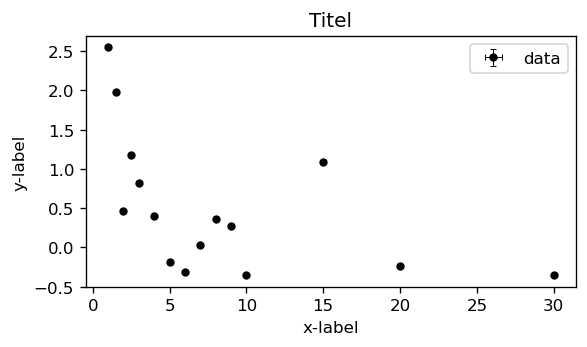

In [25]:
A_lst=[0.71225,0.88560,0.92924 ,1.047561 , 1.11749,1.18034, 1.20992, 1.22187,  1.23368 ,1.24062 , 1.24495 ,1.24865, 1.25598, 1.25889,1.25532  ]
A_err=[0.00086 ,0.00087,0.00086, 0.00087 ,0.00087 ,0.00087, 0.00087, 0.00087, 0.00087, 0.00087, 0.00087, 0.00087, 0.00087, 0.00087, 0.00087 ]
freq_lst=[1,1.5,2,2.5,3,4,5,6,7,8,9,10,15,20,30]
phi_lst=[2.54811 ,1.98181,0.45856,1.17311,0.81930,0.39807,-0.19058,-0.31327,0.03117,0.36017,0.27102, -0.35514, 1.08404, -0.23601 , -0.35204  ]
phi_err=[0.00094,0.00094,0.00094,0.00078, 0.00083, 0.00094,0.00094,0.00094,0.00094,0.00094,0.00094,0.00094,0.00094,0.00094,0.00094]
A_set=fp.Data(freq_lst,A_lst,A_err)
f_set=fp.Data(freq_lst,phi_lst,phi_err)
f_set.show()

# Opgave 3

2-3_100Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.69685 \pm      0.01544 $
For parameter f        :     $      2.57618 \pm      0.00021 $
For parameter phi      :     $     -3.00163 \pm      0.00157 $
For parameter c        :     $      0.00937 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          60.54875517
Reduced χ² value       :     χ²_red           0.63071620
P-value                :     p-value          0.99822630
----------------------------------------------------------------------------------------------------------------



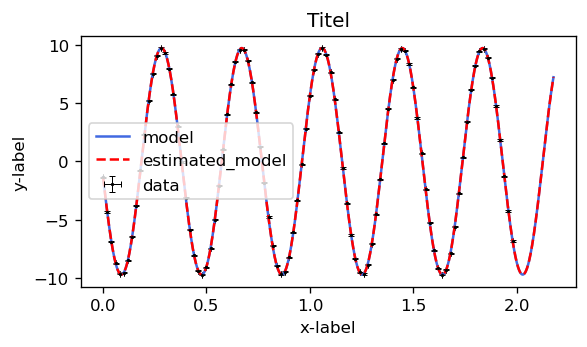





2-3_200Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.67223 \pm      0.01516 $
For parameter f        :     $      0.97676 \pm      0.00023 $
For parameter phi      :     $     -0.02212 \pm      0.00160 $
For parameter c        :     $      0.03991 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min        2858.23094101
Reduced χ² value       :     χ²_red          29.77323897
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



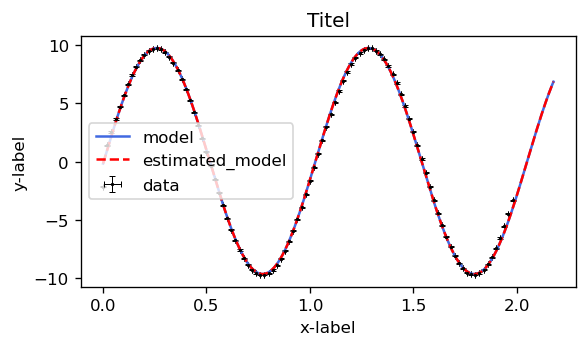





2-3_210Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     -8.57964 \pm      0.01549 $
For parameter f        :     $      1.22119 \pm      0.00030 $
For parameter phi      :     $     -1.53197 \pm      0.00177 $
For parameter c        :     $     -0.34964 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min      153518.81957244
Reduced χ² value       :     χ²_red        1599.15437055
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



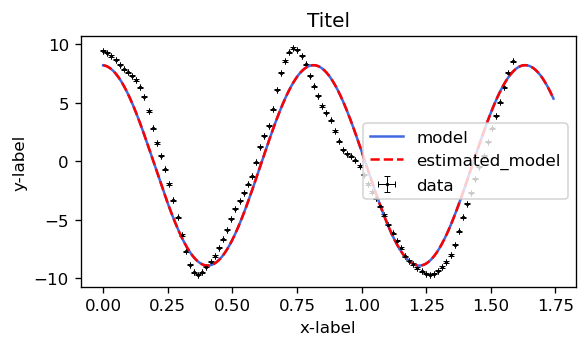





2-3_220Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.69530 \pm      0.01533 $
For parameter f        :     $      1.59376 \pm      0.00012 $
For parameter phi      :     $     -2.93694 \pm      0.00158 $
For parameter c        :     $      0.00297 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         107.65973944
Reduced χ² value       :     χ²_red           1.12145562
P-value                :     p-value          0.19564037
----------------------------------------------------------------------------------------------------------------



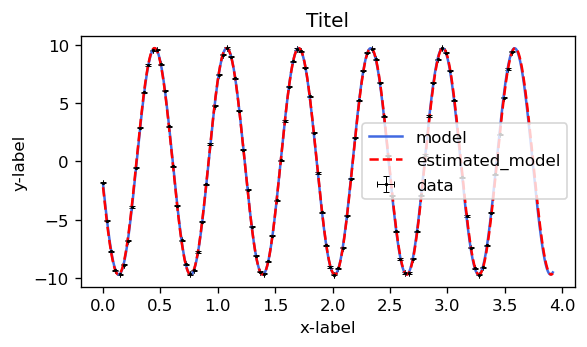





2-3_240Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.83938 \pm      0.01537 $
For parameter f        :     $      1.54819 \pm      0.00013 $
For parameter phi      :     $     -1.66139 \pm      0.00155 $
For parameter c        :     $      0.01605 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         450.11480365
Reduced χ² value       :     χ²_red           4.68869587
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



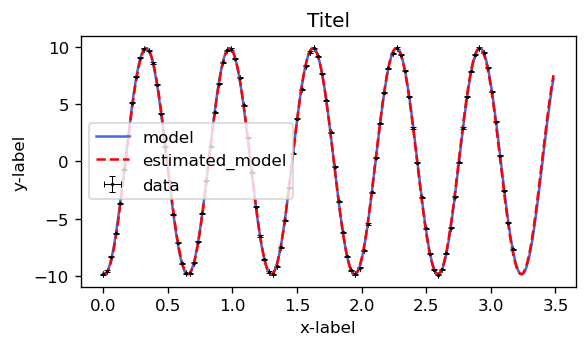





2-3_250Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.69660 \pm      0.01502 $
For parameter f        :     $      0.46289 \pm      0.00018 $
For parameter phi      :     $      0.70135 \pm      0.00161 $
For parameter c        :     $     -0.00114 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          20.21755958
Reduced χ² value       :     χ²_red           0.21059958
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



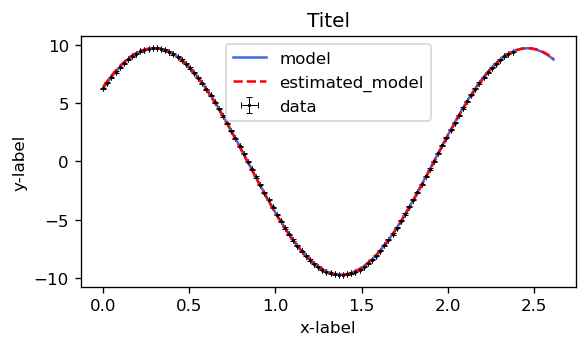





2-3_280Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.63326 \pm      0.01969 $
For parameter f        :     $      0.08179 \pm      0.00012 $
For parameter phi      :     $     -1.03920 \pm      0.00170 $
For parameter c        :     $      0.13138 \pm      0.01259 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          20.54649527
Reduced χ² value       :     χ²_red           0.29352136
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



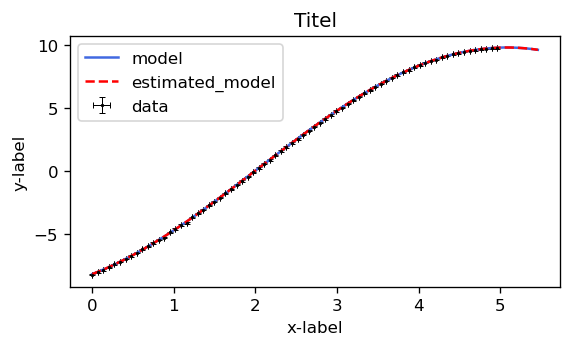





2-3_300Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.66249 \pm      0.01575 $
For parameter f        :     $      0.38783 \pm      0.00011 $
For parameter phi      :     $      4.74063 \pm      0.00154 $
For parameter c        :     $      0.04182 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         392.82876829
Reduced χ² value       :     χ²_red           4.09196634
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



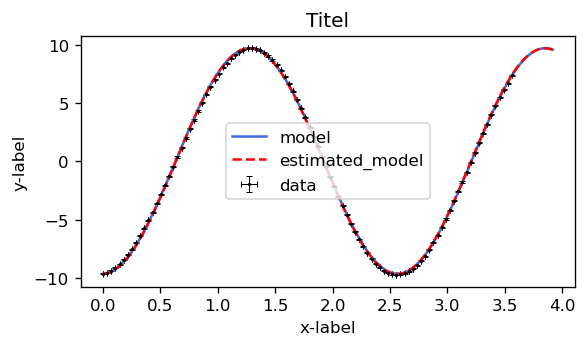

In [27]:
ERROR = 0.05
files = []
files_opdracht2 = []
for key in datadict:
    if key[0:3] == "2-3":
        files.append(fp.Data(datadict[key].x[:100], datadict[key].y[:100], ERROR*datadict[key].dy[:100], name=datadict[key].name))

def sinus_model(params, x):
    A,f,phi,c = params
    return A*np.sin(2*np.pi*f*x + phi) + c

        
for dataset in files:
    A = 10
    f = 1
    phi = -np.pi/4
    c = 1

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "guesses_opgave3.txt")
    vals = []
    var = None
    check = True

    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))))
    for var in vals:
        if var[0] == dataset.name:
            A, f, phi, c = var[1]
            check = False

    # dataset.show()
    try:
        dataset_new = dataset.fit(sinus_model, initial_guess=[A, f, phi, c])
        files_opdracht2.append(dataset_new)
        if dataset_new.chi2_red > 10:
            check = False
                
        if check:
            values = tuple([_ for _ in dataset_new.minima])
            with open(file_p, "a") as file:
                file.write(f"{dataset.name}: {values}\n")

        # WARNING: shows all fits
        if dataset_new.chi2_red > 0:
            print(dataset.name)
            print(dataset_new)
            dataset_new.show(size=1, fit_guess=True)
            print("\n\n\n")
    except ValueError:
        dataset.show()

2-4_100Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.84489 \pm      0.01525 $
For parameter f        :     $      1.85980 \pm      0.00022 $
For parameter phi      :     $     -1.46925 \pm      0.00156 $
For parameter c        :     $      0.00909 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          29.26659289
Reduced χ² value       :     χ²_red           0.30486034
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



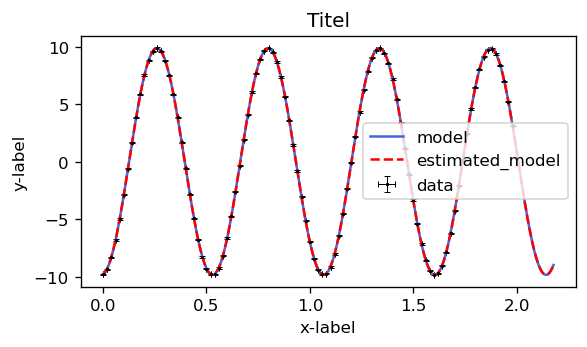





2-4_150Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      0.99709 \pm      0.01537 $
For parameter f        :     $      3.01883 \pm      0.00165 $
For parameter phi      :     $     -9.40965 \pm      0.01532 $
For parameter c        :     $     -0.24812 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     2066723.66782425
Reduced χ² value       :     χ²_red       21528.37153984
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



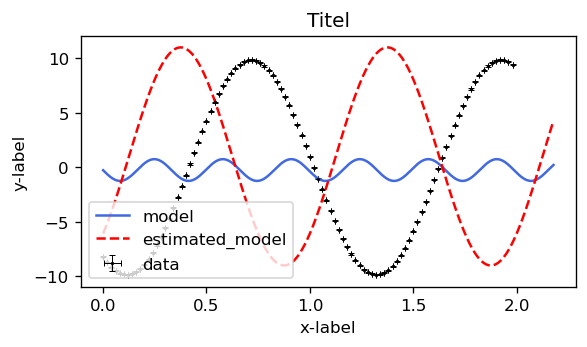





2-4_160Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     -0.71790 \pm      0.01527 $
For parameter f        :     $      1.80577 \pm      0.00103 $
For parameter phi      :     $      6.90126 \pm      0.02141 $
For parameter c        :     $      0.62150 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1868354.02908936
Reduced χ² value       :     χ²_red       19462.02113635
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



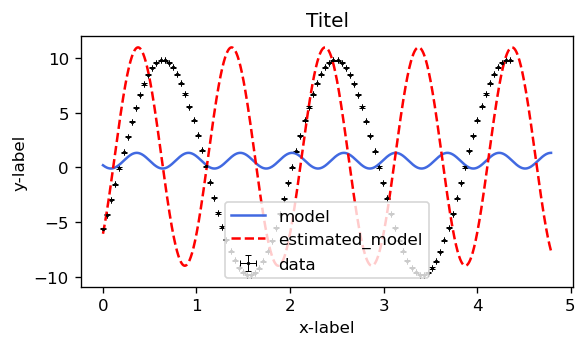





2-4_170Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      0.86907 \pm      0.01551 $
For parameter f        :     $      1.30688 \pm      0.00296 $
For parameter phi      :     $     -2.83128 \pm      0.01742 $
For parameter c        :     $      0.14803 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1921706.05543136
Reduced χ² value       :     χ²_red       20017.77141074
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



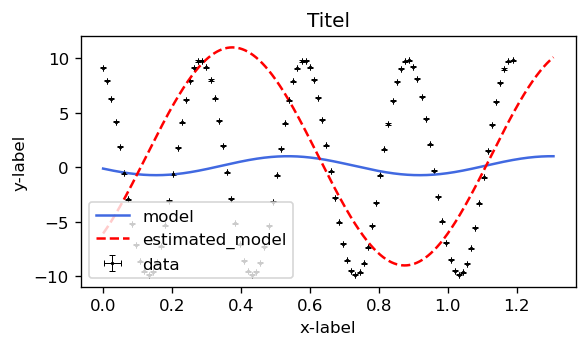





2-4_180Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      2.65457 \pm      0.01545 $
For parameter f        :     $      1.09127 \pm      0.00044 $
For parameter phi      :     $     -0.31547 \pm      0.00573 $
For parameter c        :     $      0.56230 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1907584.62447711
Reduced χ² value       :     χ²_red       19870.67317164
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



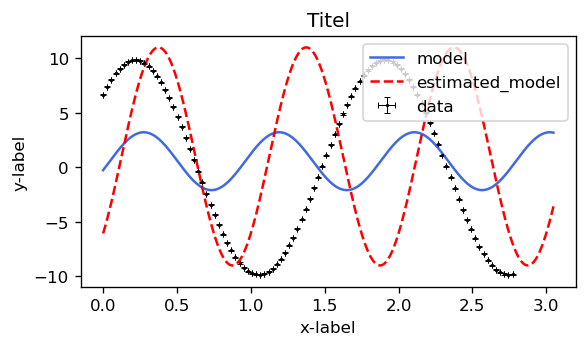





2-4_190Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      2.66177 \pm      0.01588 $
For parameter f        :     $      0.87048 \pm      0.00080 $
For parameter phi      :     $     -1.30360 \pm      0.00557 $
For parameter c        :     $     -0.08343 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1909076.78155567
Reduced χ² value       :     χ²_red       19886.21647454
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



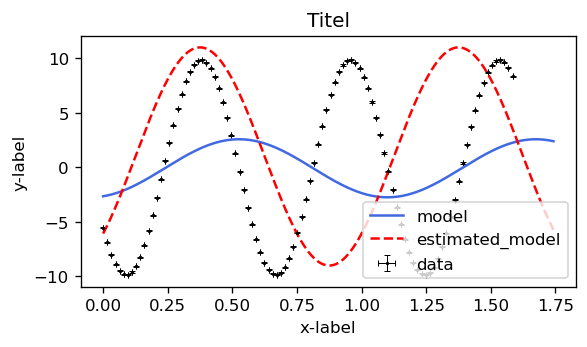





2-4_195Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      2.96655 \pm      0.01528 $
For parameter f        :     $      0.96741 \pm      0.00032 $
For parameter phi      :     $      0.20617 \pm      0.00518 $
For parameter c        :     $      0.07295 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1826991.32398390
Reduced χ² value       :     χ²_red       19031.15962483
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



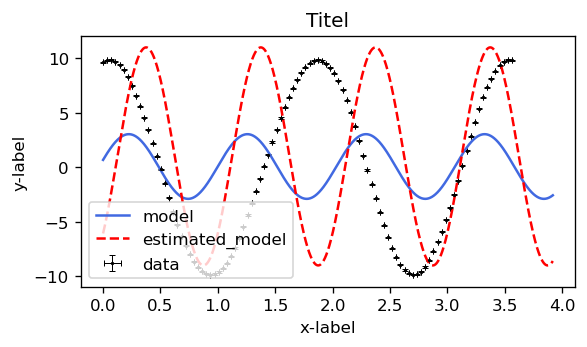





2-4_200Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.71722 \pm      0.01486 $
For parameter f        :     $      0.56936 \pm      0.00022 $
For parameter phi      :     $      0.69845 \pm      0.00163 $
For parameter c        :     $      0.18513 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min        5071.31872684
Reduced χ² value       :     χ²_red          52.82623674
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



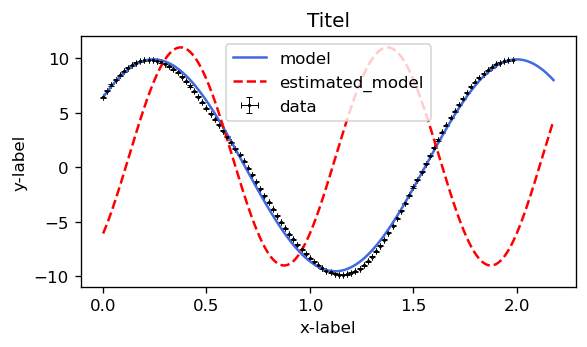





2-4_250Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $    237.35646_{-     0.01062}^{+   0.01247} $
For parameter f        :     $     -0.01336_{-     0.00002}^{+   0.00002} $
For parameter phi      :     $     -1.34301 \pm      0.00039 $
For parameter c        :     $    235.14893 \pm      0.01146 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1706186.93930955
Reduced χ² value       :     χ²_red       19839.38301523
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



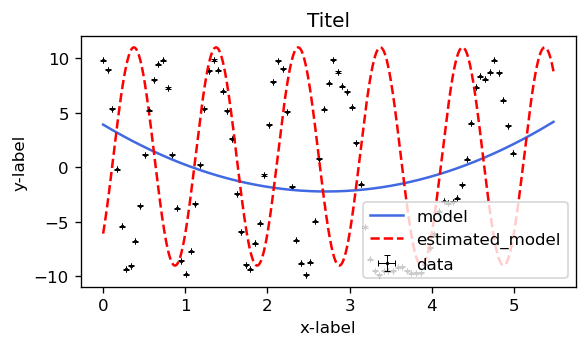





2-4_300Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      1.85526 \pm      0.01527 $
For parameter f        :     $      0.89321 \pm      0.00070 $
For parameter phi      :     $     -0.17708 \pm      0.00829 $
For parameter c        :     $      1.74940 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1772029.43640139
Reduced χ² value       :     χ²_red       18458.63996251
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



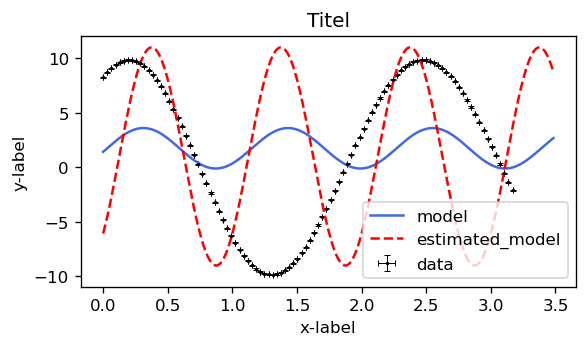

In [ ]:
ERROR = 0.05
files = []
files_opdracht2 = []
for key in datadict:
    if key[0:3] == "2-4":
        files.append(fp.Data(datadict[key].x[:100], datadict[key].y[:100], ERROR*datadict[key].dy[:100], name=datadict[key].name))

def sinus_model(params, x):
    A,f,phi,c = params
    return A*np.sin(2*np.pi*f*x + phi) + c

        
for dataset in files:
    A = 10
    f = 1
    phi = -np.pi/4
    c = 1

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "guesses_opgave4.txt")
    vals = []
    var = None
    check = True

    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))))
    for var in vals:
        if var[0] == dataset.name:
            A, f, phi, c = var[1]
            check = False

    # dataset.show()
    try:
        dataset_new = dataset.fit(sinus_model, initial_guess=[A, f, phi, c])
        files_opdracht2.append(dataset_new)
        if dataset_new.chi2_red > 10:
            check = False
                
        if check:
            values = tuple([_ for _ in dataset_new.minima])
            with open(file_p, "a") as file:
                file.write(f"{dataset.name}: {values}\n")

        # WARNING: shows all fits
        if dataset_new.chi2_red > 0:
            print(dataset.name)
            print(dataset_new)
            dataset_new.show(size=1, fit_guess=True)
            print("\n\n\n")
    except ValueError:
        dataset.show()

2-5_100Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $    519.26721 \pm      0.01088 $
For parameter f        :     $     -0.02405 \pm      0.00003 $
For parameter phi      :     $      1.71819 \pm      0.00024 $
For parameter c        :     $   -518.12478 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1767348.57769910
Reduced χ² value       :     χ²_red       18409.88101770
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



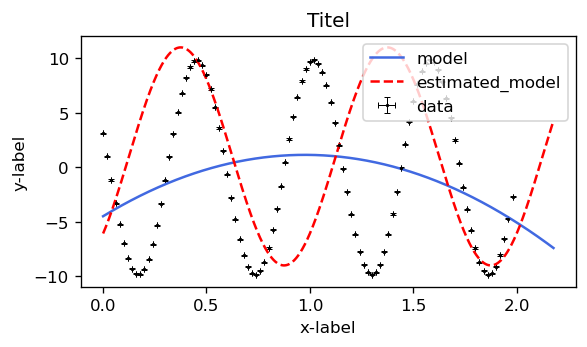





2-5_150Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      0.77388 \pm      0.01543 $
For parameter f        :     $     -3.29647 \pm      0.00220 $
For parameter phi      :     $     28.37992 \pm      0.01967 $
For parameter c        :     $      0.92128 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     2026738.89831255
Reduced χ² value       :     χ²_red       21111.86352409
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



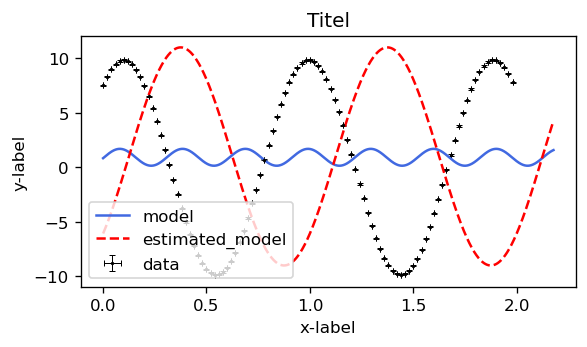





2-5_160Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     -2.14028 \pm      0.01519 $
For parameter f        :     $      1.52860 \pm      0.00036 $
For parameter phi      :     $     -2.43082 \pm      0.00722 $
For parameter c        :     $     -0.09495 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1818352.36649968
Reduced χ² value       :     χ²_red       18941.17048437
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



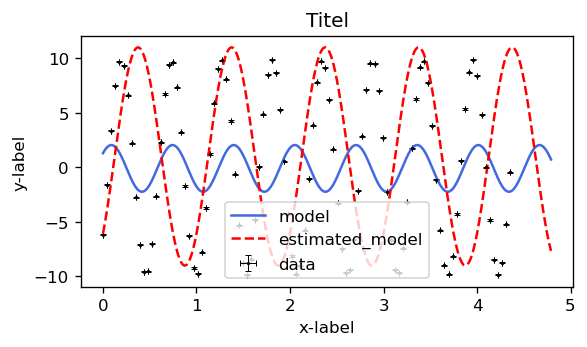





2-5_170Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $    654.04859 \pm      0.01087 $
For parameter f        :     $      0.03465 \pm      0.00004 $
For parameter phi      :     $      1.45122 \pm      0.00022 $
For parameter c        :     $   -652.77603 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1834458.48572454
Reduced χ² value       :     χ²_red       19108.94255963
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



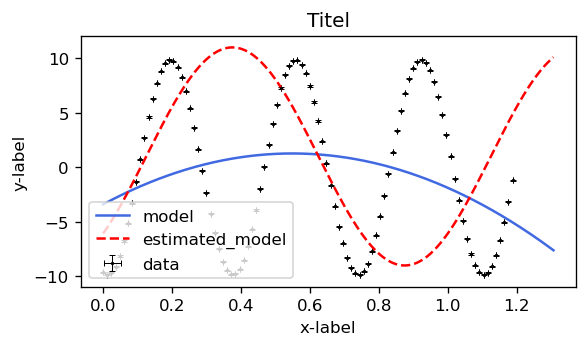





2-5_180Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      1.58485 \pm      0.01536 $
For parameter f        :     $      0.71013 \pm      0.00087 $
For parameter phi      :     $      1.84327 \pm      0.00964 $
For parameter c        :     $      0.60117 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1855353.14747260
Reduced χ² value       :     χ²_red       19326.59528617
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



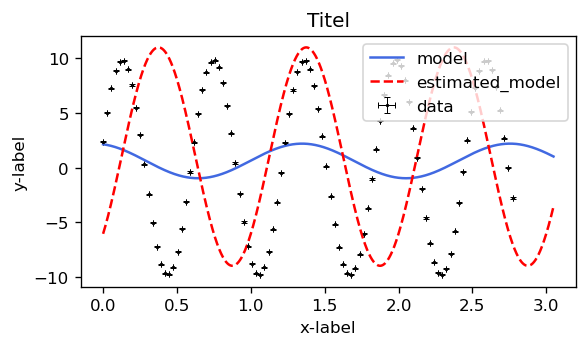





2-5_185Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      2.32876 \pm      0.01689 $
For parameter f        :     $      0.38325 \pm      0.00031 $
For parameter phi      :     $      1.39497 \pm      0.00711 $
For parameter c        :     $      0.73888 \pm      0.01182 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1528922.43546787
Reduced χ² value       :     χ²_red       19111.53044335
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



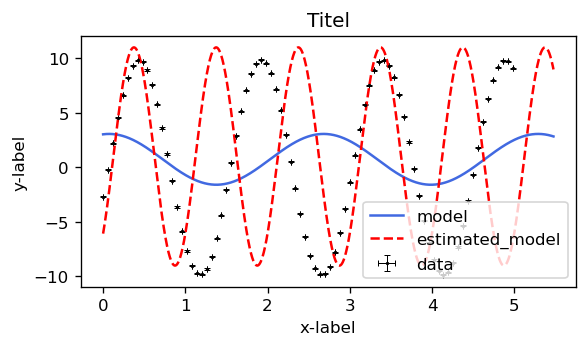





2-5_190Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      2.41231 \pm      0.01581 $
For parameter f        :     $      0.86315 \pm      0.00092 $
For parameter phi      :     $     -1.49833 \pm      0.00617 $
For parameter c        :     $     -0.21349 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min     1867699.03617701
Reduced χ² value       :     χ²_red       19455.19829351
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



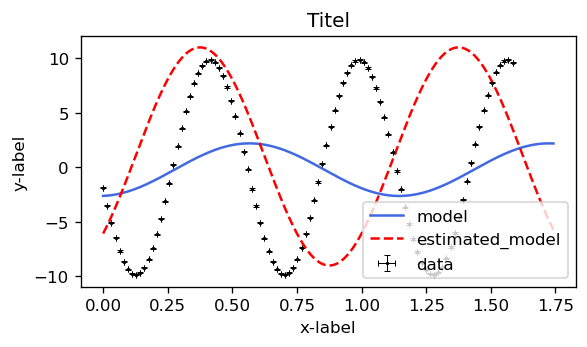





2-5_200Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.73215 \pm      0.01544 $
For parameter f        :     $      0.72690 \pm      0.00023 $
For parameter phi      :     $     -0.85083 \pm      0.00156 $
For parameter c        :     $      0.11267 \pm      0.01083 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         678.90366659
Reduced χ² value       :     χ²_red           7.07191319
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



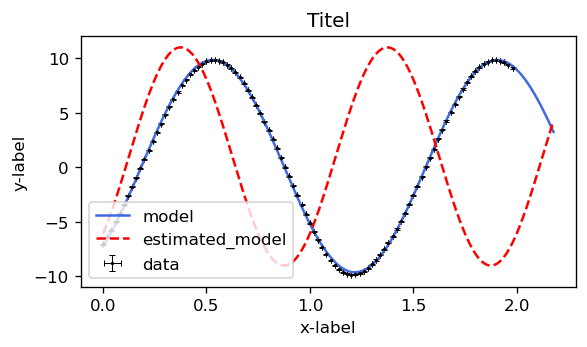

In [29]:
ERROR = 0.05
files = []
files_opdracht2 = []
for key in datadict:
    if key[0:3] == "2-5":
        files.append(fp.Data(datadict[key].x[:100], datadict[key].y[:100], ERROR*datadict[key].dy[:100], name=datadict[key].name))

def sinus_model(params, x):
    A,f,phi,c = params
    return A*np.sin(2*np.pi*f*x + phi) + c

        
for dataset in files:
    A = 10
    f = 1
    phi = -np.pi/4
    c = 1

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "guesses_opgave3.txt")
    vals = []
    var = None
    check = True

    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))))
    for var in vals:
        if var[0] == dataset.name:
            A, f, phi, c = var[1]
            check = False

    # dataset.show()
    try:
        dataset_new = dataset.fit(sinus_model, initial_guess=[A, f, phi, c])
        files_opdracht2.append(dataset_new)
        if dataset_new.chi2_red > 10:
            check = False
                
        if check:
            values = tuple([_ for _ in dataset_new.minima])
            with open(file_p, "a") as file:
                file.write(f"{dataset.name}: {values}\n")

        # WARNING: shows all fits
        if dataset_new.chi2_red > 0:
            print(dataset.name)
            print(dataset_new)
            dataset_new.show(size=1, fit_guess=True)
            print("\n\n\n")
    except ValueError:
        dataset.show()